In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [53]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [54]:
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=70, marker='o', c='blue', facecolors='none', 
               linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, linewidth=1)
    ax.axhline(y=12, linewidth=1)
    ax.axvline(x=175, linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

In [55]:
X, y = load_coffee_data()
print(X.shape, y.shape)

(200, 2) (200, 1)


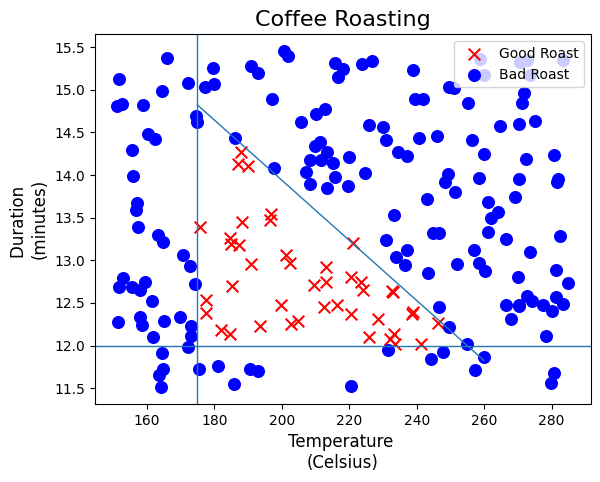

In [56]:
plt_roast(X, y)

In [57]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [58]:
Xt = np.tile(Xn,(1000,1))
yt= np.tile(y,(1000,1))   
print(Xt.shape, yt.shape)  

(200000, 2) (200000, 1)


In [59]:
tf.random.set_seed(1234)
model = Sequential([
    tf.keras.Input(shape=(2,)),
    Dense(units=3, activation="sigmoid", name="layer1"),
    Dense(units=1, activation="sigmoid", name="layer2")
])

In [60]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


In [62]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()

print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.22567928  0.06093538  0.16215539]
 [-0.7225465   0.48228717  0.27978837]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.91749775]
 [-0.61493975]
 [-0.611653  ]] 
b2(1,): [0.]


In [63]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
)

model.fit(
    Xt, yt,
    epochs=10,
    batch_size=32 # default
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 953us/step - loss: 0.1938
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 926us/step - loss: 0.1186
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 972us/step - loss: 0.0441
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0172
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0114
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0081
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0059
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0043
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0032
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0023


In [64]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()

print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 1.28973103e+01  1.44577713e+01 -1.07512549e-02]
 [ 2.84606367e-01  1.20988455e+01 -9.00603580e+00]] 
b1(3,): [ 13.515933    1.8216369 -11.27252  ]
W2(3, 1):
 [[ 39.247738]
 [-43.678642]
 [-46.26169 ]] 
b2(1,): [-12.637065]


In [68]:
def compute_yhat(predictions):
    yhat = np.zeros_like(predictions)
    for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            yhat[i] = 1
        else:
            yhat[i] = 0
    return yhat

In [69]:
X_test = np.array([[200, 13.9], [200, 17]])

### There are 2 ways to predict
1. Normalization X_test

In [ ]:
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("Predictions = \n", predictions)

yhat = compute_yhat(predictions)
print("Decision = \n", yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predictions = 
 [[9.7499871e-01]
 [3.8336253e-08]]
Decision = 
 [[1.]
 [0.]]


2. Unscale

In [72]:
W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()

print(f"W1 = {W1}, b1 = {b1}\nW2 = {W2}, b2 = {b2}")

W1 = [[ 1.28973103e+01  1.44577713e+01 -1.07512549e-02]
 [ 2.84606367e-01  1.20988455e+01 -9.00603580e+00]], b1 = [ 13.515933    1.8216369 -11.27252  ]
W2 = [[ 39.247738]
 [-43.678642]
 [-46.26169 ]], b2 = [-12.637065]


In [ ]:
mean = norm_l.mean.numpy()
std = np.sqrt(norm_l.variance.numpy())

[[218.66783   13.430685]] [[39.961655   1.1284171]]


In [ ]:
# Unscale in first layer

W1_new = W1 / std.reshape(-1, 1)
b1_new = b1 - np.dot(mean, W1_new)

### Explain why only the first layer is unscaled
- When you normalize the input with an affine transform
  $$
  x^{'} = \frac{x - \mu}{\sigma},
  $$
  and the first layer of your network is a Dense layer (linear + activation), then the normalization can be **folded into that first linear transformation**.
- Specifically, you can rewrite
  $$
  z = x^{'}W + b = (\frac{x - \mu}{\sigma})W + b
  $$
  as
  $$
  z = xW_{new} + b_new,
  $$
  with
  $$
  \begin{cases}
  W_{new} = \frac{W}{\sigma} \\
  b_{new} = b - (\frac{\mu}{\sigma})@W
  \end{cases}
  $$
- This way, the first layer directly consumes the raw input x, but produces exactly the same pre-activation output z as before. Since the output of the first layer doesn't change, all subsequent layers receive identical inputs and remain untouched.
- `Conclusion`: if normalization is only applied to the input, you only need to “unscale” (adjust) the first layer’s weights and bias. All later layers stay the same.

In [83]:
model_raw = Sequential([
    tf.keras.Input(shape=(2,)),
    Dense(units=3, activation="sigmoid", name="layer1"),
    Dense(units=1, activation="sigmoid", name="layer2")
])

model_raw.layers[0].set_weights([W1_new, b1_new.flatten()])
model_raw.layers[1].set_weights([W2, b2])

In [84]:
X_test = np.array([[200, 13.9], [200, 17]])

predictions = model_raw.predict(X_test)
print("Predictions = \n", predictions)

yhat = compute_yhat(predictions)
print("Decision = \n", yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predictions = 
 [[9.7499669e-01]
 [3.8336253e-08]]
Decision = 
 [[1.]
 [0.]]
